# Sequential regression models

Sequential regression models are a a special case of ordinal models, where the different categories can only be reached one after another, i.e., sequentially. Sequential response mechanisms frequently occur in biological and medical settings, i.e., titer data or MIC data, but haven't received much attention in applied research.

In this case study, we analyse two ordinal data sets for which an underlying sequential response mechanism can be assumed and compare it to the more common cumulative model.

The relevant code can be found [here](https://github.com/dirmeier/pystansequential). I implemented an R-package that wraps the functions for convencience. The package relies on [`rstan`](https://github.com/stan-dev/rstan/) for inference.

In [1]:
suppressMessages({
    library(tidyverse)
    library(colorspace)
    library(patchwork)
    library(bayesplot)    
    
    library(rstan)
    library(loo)
    library(rstansequential)    
})

options(mc.cores = max(1, parallel::detectCores() - 1))
options(repr.plot.width = 14, repr.plot.height = 8)

## Cumulative models

The conventional cumulative model introduced by [McCullagh (1980)](https://doi.org/10.1111/j.2517-6161.1980.tb01109.x) is probably the most frequently encountered ordinal regression model. It assumes a response variable $Y$ with $K$ ordered categories $k = 1, \dots, K$ and ordinal probabilities $\pi_1, \dots, \pi_K$. The model is motivated by a latent continuous random process $\tilde{Y}$

$$\begin{align}
\tilde{Y} & = -\mathbf{x}^T \boldsymbol \beta + \epsilon \\
\epsilon & \sim f
\end{align}
$$

for some density $f$. The latent variable is related to the observed category with a threshold mechanism

$$\begin{align}
Y = k \Leftrightarrow \theta_{k - 1} < \tilde{Y} \le \theta_{k}, \; k = 1, \dots, K
\end{align}
$$

for a set of latent ordered continuous cutpoints $\theta_0, \dots, \theta_K$ with $\theta_0 = -\infty$ and $\theta_K = \infty$.

From this assumption one obtains

$$\begin{align}
P(Y \le  k) & = P(\tilde{Y} \le \theta_k) \\
& = P(-\mathbf{x}^T \boldsymbol \beta +\epsilon \le \theta_k) \\
& = P(\epsilon \le \theta_k + \mathbf{x}^T \boldsymbol \beta) \\
&= F(\theta_k + \mathbf{x}^T \boldsymbol \beta),
\end{align}$$

which gives rise to the name *cumulative* (because of the cumulative probabilities). Computing the ordinal probabilities form this gives

$$\begin{align}
\pi_k & = F(\theta_k + \mathbf{x}^T \boldsymbol \beta) - F(\theta_{k - 1} + \mathbf{x}^T \boldsymbol \beta)
\end{align}$$

The choice of the distribution function $F$ determines which model we obtain. The cumulative *logit* model (i.e., choosing a logit link function) is obtained if we choose a logistic distribution function

$$\begin{align}
P(Y \le k) = \frac{1}{1 + \exp(-\theta_k - \mathbf{x}^T \boldsymbol \beta)}
\end{align}$$ 

or equivalently a *logit* link which gives us the *cumulative* log odds

$$\begin{align}
F^{-1}\left( P(Y \le k) \right) = \log \frac{P(Y \le k)}{1 - P(Y \le k)} = \theta_k + \mathbf{x}^T \boldsymbol \beta
\end{align}$$ 

If we look at the odds ratio of the event $Y \le k$ for two populations characterized by covariable values $\mathbf{x}$ and $\mathbf{\tilde{x}}$

$$\begin{align}
\frac{P(Y \le k \mid \mathbf{x})\ / \ P(Y > k  \mid \mathbf{x}) }{P(Y \le k \mid \mathbf{\tilde{x}})\ / \ P(Y > k 
\mid \mathbf{\tilde{x}}) } & = \frac{ \exp\left( \theta_k + \mathbf{x}^T \boldsymbol \beta \right)}{\exp\left(\theta_k + \mathbf{\tilde{x}}^T \boldsymbol \beta \right)} \\
& = \exp\left( \left(  \mathbf{x} - \mathbf{\tilde{x}}\right)^T \boldsymbol \beta  \right)
\end{align}$$ 

we see that the ratio of odds is the same regardless of the category. This assumption is also called *proportional odds* and the model *proportional odds model*. The derivation is crucial for the interpretation of coefficients and makes it especially simple, because it says that the ratio of the cumulative odds of two populations are the same irrespective of the category. Hence we can disregard the categories when we interpret coefficients.

## Sequential models

In some applications if makes more sense to assume that the categories can only be reached sequentially. For instance, to gain the title of "PhD" in the ordering of degrees "Bachelor < Master < PhD" first Bacherlor and Master titles have to be obtained. Analogously, if the response variable is the number of guitar someone owns, one can assume that the guitars have been bought successively, and not, as a cumulative model assumes, all at the same time. Thus, the number of guitars can be considered to be a "sequential" ordinal random variable. The sequential model has (afaik) been introduced by [Tutz (1991)](https://doi.org/10.1016/0167-9473(91)90086-H). 

In the literature, multiple names has been used for sequential regression models, such as calls *continuation ratio* models by Tutz. [Yee (2010)](http://dx.doi.org/10.18637/jss.v032.i10) calls them *stopping ratio* models which seems to be a better fitting name.

As in the cumulative model, we assume a latent continuous process $\tilde{Y} = - \mathbf{x}^T \boldsymbol \beta + \epsilon$. For the sequential model it relates to the observed random variable $Y$ via

$$\begin{align}
P(Y =  k \mid Y \ge k) =  F(\theta_k + \mathbf{x}^T \boldsymbol \beta) \\
\end{align}
$$

As above, $k = 1, \dots, K$, $\theta_0, \dots, \theta_K$ are cutpoints with $\theta_0 = -\infty$ and $\theta_K = \infty$ and $F$ is a cumulative distribution function.

In order to reach a category $k$, $Y$ has to go through all the previous categories. For instance, for any $Y$, we first compute

$$\begin{align}
P(Y = 1) = F(\theta_1 + \mathbf{x}^T \boldsymbol \beta)
\end{align}$$ 

and stop the process if the Bernoulli experiment is successful. If it is not successful, i.e, $Y \ge 2$, we do another experiment between $Y=2$ and $Y >2$:

$$\begin{align}
P(Y = 2 \mid Y \ge 2) = F(\theta_2 + \mathbf{x}^T \boldsymbol \beta)
\end{align}$$ 

If this is successful, we stop. Otherwise we continue the process. At the end of the process, the ordinal propability for category $k$ is

$$\begin{align}
\pi_k & = (Y = k \mid Y \ge k) \prod_{l = 1}^{k - 1} 1 - P(Y = l \mid Y \ge l) \\
& = F(\theta_k + \mathbf{x}^T \boldsymbol \beta) \prod_{l = 1}^{k - 1} 1 - F(\theta_l + \mathbf{x}^T \boldsymbol \beta)
\end{align}$$

As for the cumulative model, the most frequent choice of $F$ is probably the cumulative distribution function of the logistic distribution. Hence

$$\begin{align}
P(Y =  k \mid Y \ge k) = \frac{1}{1 + \exp(-\theta_k - \mathbf{x}^T \boldsymbol \beta)}
\end{align}$$ 

or equivalently the logit

$$\begin{align}
F^{-1}\left( Y =  k \mid Y \ge k \right) = \log \frac{P(Y =  k \mid Y \ge k)}{1 - P(Y =  k \mid Y \ge k)} = \theta_k + \mathbf{x}^T \boldsymbol \beta
\end{align}$$ 

The logit is a ratio of the probability that the respose category *stops* at $k$ and the probability of the categories $\{k + 1, \dots, K \}$. As in the cumulative model, the odds ratio does not depend on the category which makes the model *a* proportional odds model as well.

## Data

We apply the two models above to a wine data set from [Randall (1989)](https://doi.org/10.1002/bimj.4710310703) and [Tutz *et al.* (1996)](https://doi.org/10.1016/0167-9473(96)00004-7) where nine judges assessed the bitterness of wine. When tasting the wines judges gave a statement about the bitterness of wine on a
scale from least to most bitter. I extracted the data from the papers and put added them to the `rstansequential` package. Let's visualize the data first.

In [2]:
data(wine)

In [3]:
head(wine)

rating,temperature,contact,bottle,judge
<ord>,<fct>,<fct>,<fct>,<fct>
2,low,no,1,1
1,low,no,1,2
2,low,no,1,3
3,low,no,1,4
2,low,no,1,5
3,low,no,1,6


The response `rating` determines the bitterness of the wine from least to most bitter. When the grapes were crushed `temperature` could be controlled and set to either `low` or `high`. Furthermore, `contact` determines whether grapes had contact to the skin. For each treatment combination two `bottles` have been fermented. 

I first pivot the data frame around the response `rating` such that we can nicely plot it.

In [4]:
wide.wine <- wine %>%
    dplyr::select(-judge) %>%
    tidyr::pivot_longer(-rating, names_to="covariable", values_to = "value")

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


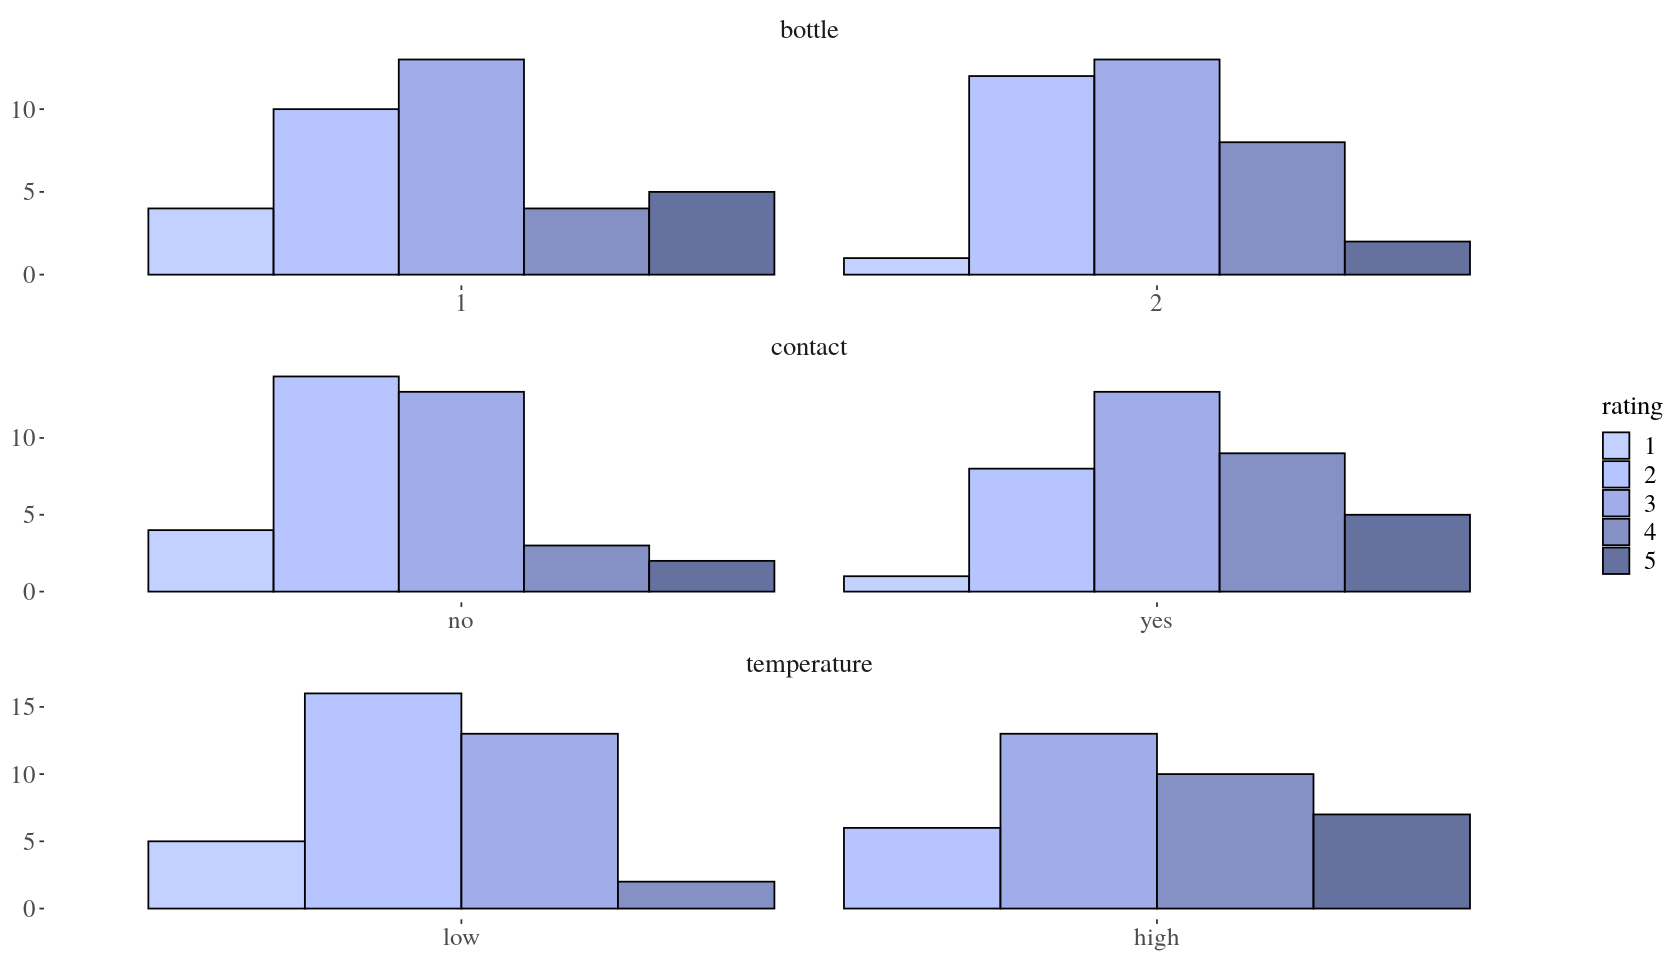

In [5]:
g <- ggthemes::theme_tufte() +
     ggplot2::theme(axis.title = element_blank(), 
                    axis.text = element_text(size=15),
                    legend.text = element_text(size=15),
                    legend.title = element_text(size=16),
                    strip.text = element_text(size=16))

ggplot2::ggplot(wide.wine) +
    ggplot2::geom_histogram(
        aes(x=value, fill=rating), 
        color="black", 
        stat="count", position = "dodge") +     
    colorspace::scale_fill_discrete_sequential(c1=50, c2=80, l1=30, l2=80, alpha=0.75) + 
    ggplot2::facet_wrap(. ~ covariable, nrow = 3, scales = "free") +
    g

The bars show the ratings of the independent judges given the covariables `bottle`, `contact` and `temperature`.  For the second and third plot, i.e., `contact=yes` and `temperature=high` the ratings seem higher than for the other levels. In order to account for heterogeneity of the judges, we should assume that each has its own sensitivity for bitterness of the wines resulting in correlation of the errors. Hence, we add a group-level coefficient, such that the latent process becomes

$$\begin{align}
\tilde{Y}_j = - \mathbf{x}^T \boldsymbol \beta - \gamma_j + \epsilon,
\end{align}$$ 

for judges $j = 1, \dots, 9$. The vector $\mathbf{x}$ is a vector of the dummy encoded covariables `contact`, `bottle` and `temperature` and $\gamma_j$ are group-specific intercepts. In a recent case study I explained hierarchical models in more detail ([link](https://dirmeier.github.io/mixed-models/index.html)) so have a look if this notation is unclear.

## Stan models

The stan models for both the cumulative and the sequential models are with the exception of the likelihood the same. For demonstration, let's go through the stan file of the cumulative model. The first pars

## Cumulative model fit

With the theory derived and the linear predictor constructed we can fit the models. The stan code for the cumulative log probability mass function is fairly short:

In [6]:
cat(
    readLines(
        system.file(file.path("stan", "include", "cumulative.stan"), package = "rstansequential")
    ),
    sep="\n"
)


real marg_prob_cumul_logit(int y, real eta, vector c, int K) {
  real val = 0;
   if (y == 1) {
      val = inv_logit(c[1] - eta);
    }
    else if (1 < y && y < K) {
      val = inv_logit(c[y] - eta) - inv_logit(c[y - 1] - eta);
    }
    else {
      val = 1 - inv_logit(c[y - 1] - eta);
    }

    return val;
}


real cumulative_lpmf(int[] y, vector eta, vector c) {
  int N = num_elements(y);
  int K = num_elements(c) + 1;
  real lpmf = 0;

  for (i in 1:N) {
    lpmf += log(marg_prob_cumul_logit(y[i], eta[i], c, K));
  }

  return lpmf;
}


real cumulative_scalar_lpmf(int y, real eta, vector c) {
  int K = num_elements(c) + 1;
  return log(marg_prob_cumul_logit(y, eta, c, K));
}


Fitting the model can be done like this using `rstansequential` (we set `refresh=-1` to avoid most of the output of `rstan`):

In [7]:
wine_fit_cumulative = fit(
    rating ~ bottle + contact + temperature + (1 | judge), 
    wine, 
    family="cumulative", refresh=-1
)

Chain 1: 
Chain 1: Gradient evaluation took 4.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0.379749 seconds (Warm-up)
Chain 1:                0.345133 seconds (Sampling)
Chain 1:                0.724882 seconds (Total)
Chain 1: 
Chain 2: 
Chain 2: Gradient evaluation took 2.3e-05 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: 
Chain 2:  Elapsed Time: 0.423656 seconds (Warm-up)
Chain 2:                0.295127 seconds (Sampling)
Chain 2:                0.718783 seconds (Total)
Chain 2: 
Chain 3: 
Chain 3: Gradient evaluation took 2.6e-05 seconds
Chain 3: 1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
Chain 3: Adjust your expectations accordingly!
Chain 3: 
Chain 3: 
Chain

Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


In [11]:
print(wine_fit_cumulative, pars = c("threshold", "beta", "gamma", "sigma"))

Inference for Stan model: hierarchical_cumulative.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
threshold[1] -1.85    0.02 0.72 -3.39 -2.31 -1.80 -1.34 -0.49  1661 1.00
threshold[2]  1.08    0.01 0.60 -0.11  0.70  1.07  1.47  2.32  1721 1.00
threshold[3]  3.51    0.02 0.71  2.17  3.03  3.50  3.97  4.95  1923 1.00
threshold[4]  5.27    0.02 0.84  3.72  4.68  5.24  5.85  7.01  1551 1.00
beta[1]       0.18    0.01 0.42 -0.64 -0.09  0.18  0.46  1.01  4583 1.00
beta[2]       1.39    0.01 0.42  0.56  1.10  1.39  1.68  2.24  3639 1.00
beta[3]       2.33    0.01 0.48  1.42  2.02  2.31  2.64  3.31  2833 1.00
gamma[1]      1.44    0.02 0.75  0.09  0.91  1.41  1.94  2.95  1031 1.00
gamma[2]     -0.53    0.02 0.71 -2.09 -0.98 -0.48 -0.05  0.74  2066 1.00
gamma[3]      0.84    0.02 0.69 -0.39  0.36  0.81  1.28  2.31  1775 1.00
gamma[4]     -0.07    0.01 0

The fit shows (from top to bottom), the estimates for the four cutpoints (called threshold here). We obtain $c=4$ cutpoints since we used $K = c + 1$ categories. The next set of parameters are the coefficients of the covariables `bottle=2`, `contact=yes` and  `temperature=high`. Note that we do not have intercepts in the model matrix. The rest are the coefficients for the group-level intercepts and their standard deviation.

The effective sample sizes are decent given that we used a centered parameterization and the R-hats are optimal. Before we continue, we plot the traces and histograms of posteriors, and HMC energy diagnostics.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



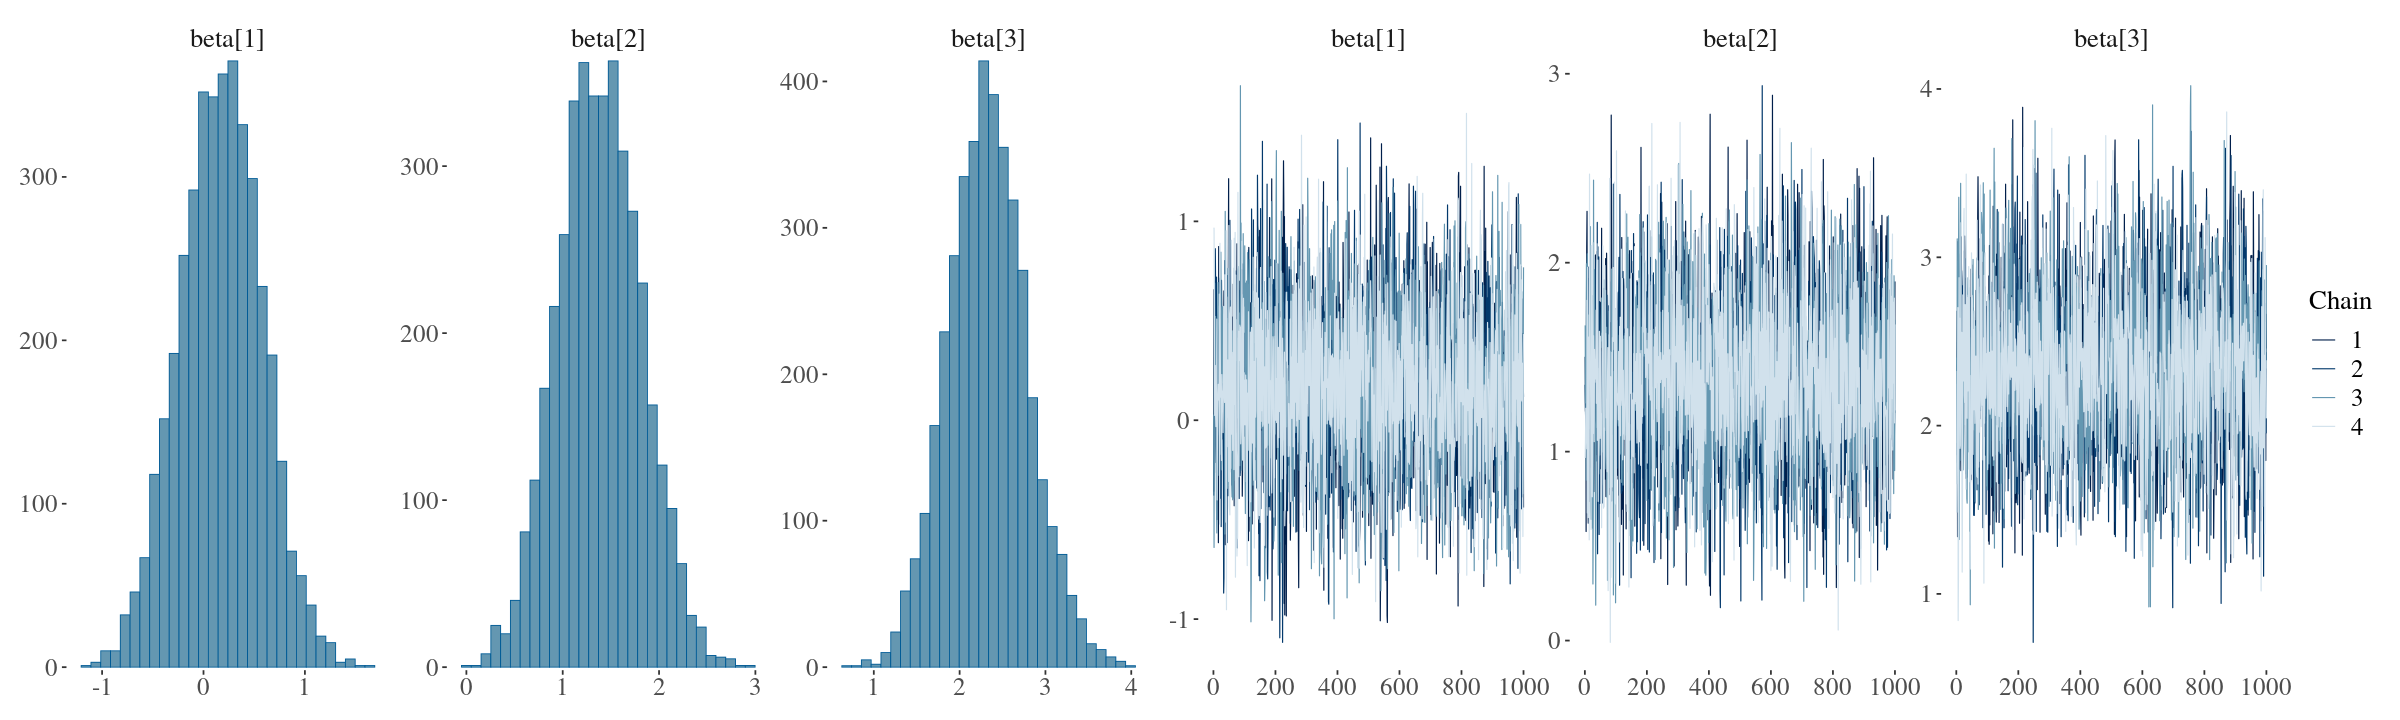

In [82]:
options(repr.plot.width = 20, repr.plot.height = 6)

trace.plot <- bayesplot::mcmc_trace(wine_fit_cumulative, regex_pars = "beta") 
hist.plot  <- bayesplot::mcmc_hist(wine_fit_cumulative, regex_pars = "beta")

(hist.plot + g) + (trace.plot + g)

The HMC energy diagnostics consists of two histograms per chain. Rougly speaking, if the two histograms overlap the HMC will rapidly explore the target distribution. If they don't overlap, the sampler may not sufficiently explore the tails of the distribution and autocorrelation of the chain is large.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



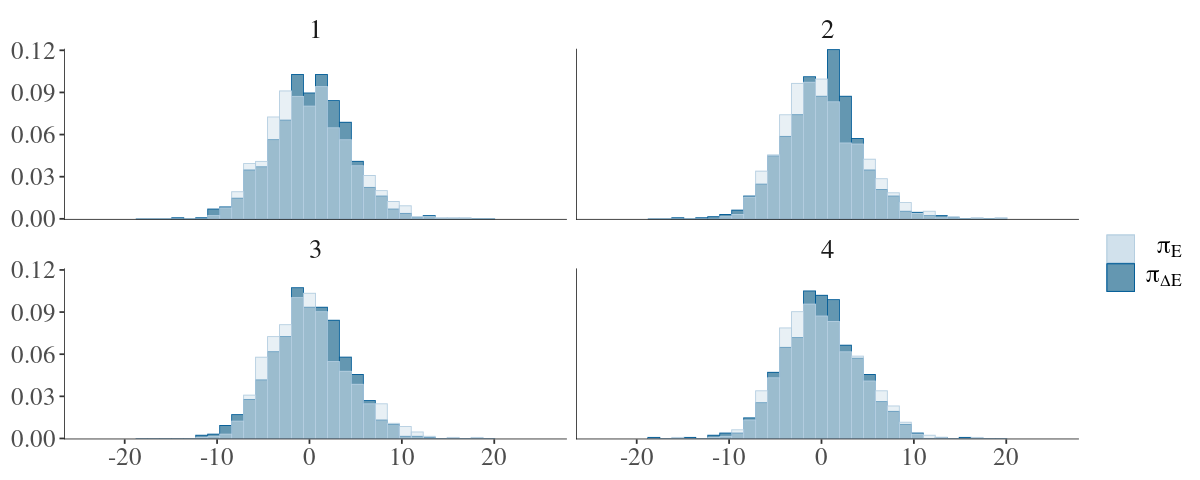

In [90]:
options(repr.plot.width = 10, repr.plot.height = 4)

params <- bayesplot::nuts_params(wine_fit_cumulative)
bayesplot::mcmc_nuts_energy(params) + g

## Sequential model fit

We now fit the sequential model. The stan code for its log probability mass function looks like this:

In [84]:
cat(
    readLines(
        system.file(file.path("stan", "include", "sratio.stan"), package = "rstansequential")
    ),
    sep="\n"
)

real marg_prob_stop_ratio(int y, real eta, vector c, int K) {
  real val = 0;
  if (y < K) {
    val += inv_logit(c[y] - eta);
    if (y > 1) {
      for (i in 1:(y - 1)) {
        val *= 1 - inv_logit(c[i] - eta);
      }
    }
  }
  else {
    val = prod(1 - inv_logit(c[1:(K - 1)] - eta));
  }

  return val;
}

real sratio_lpmf(int[] y, vector eta, vector c) {
  int N = num_elements(y);
  int K = num_elements(c) + 1;
  real lpmf = 0;

  for (i in 1:N) {
    lpmf += log(marg_prob_stop_ratio(y[i], eta[i], c, K));
  }

  return lpmf;
}


To fit the model, we just change the family to `sratio` from `cumulative`.

In [12]:
wine_fit_sratio = fit(
    rating ~ bottle + contact + temperature + (1 | judge), 
    wine, 
    family="sratio", refresh=-1
)

Chain 1: 
Chain 1: Gradient evaluation took 4.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0.526336 seconds (Warm-up)
Chain 1:                0.562732 seconds (Sampling)
Chain 1:                1.08907 seconds (Total)
Chain 1: 
Chain 2: 
Chain 2: Gradient evaluation took 4.9e-05 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: 
Chain 2:  Elapsed Time: 0.512379 seconds (Warm-up)
Chain 2:                0.480772 seconds (Sampling)
Chain 2:                0.993151 seconds (Total)
Chain 2: 
Chain 3: 
Chain 3: Gradient evaluation took 2.8e-05 seconds
Chain 3: 1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Chain 3: Adjust your expectations accordingly!
Chain 3: 
Chain 3: 
Chain 

In [13]:
print(wine_fit_sratio, pars = c("threshold", "beta", "gamma", "sigma"))

Inference for Stan model: hierarchical_sratio.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
threshold[1] -1.88    0.02 0.68 -3.31 -2.32 -1.86 -1.42 -0.59  1855    1
threshold[2]  0.86    0.01 0.58 -0.24  0.48  0.86  1.22  2.04  2052    1
threshold[3]  2.84    0.02 0.71  1.51  2.36  2.83  3.29  4.31  1585    1
threshold[4]  4.04    0.02 0.90  2.35  3.42  4.02  4.62  5.91  1538    1
beta[1]       0.03    0.01 0.36 -0.70 -0.21  0.03  0.28  0.75  2986    1
beta[2]       1.26    0.01 0.40  0.51  0.99  1.26  1.53  2.05  2901    1
beta[3]       2.17    0.01 0.43  1.35  1.88  2.17  2.47  3.03  2369    1
gamma[1]      1.18    0.02 0.68  0.01  0.70  1.12  1.61  2.62  1519    1
gamma[2]     -0.37    0.01 0.60 -1.62 -0.74 -0.32  0.04  0.75  2411    1
gamma[3]      0.85    0.02 0.63 -0.23  0.41  0.82  1.23  2.20  1682    1
gamma[4]      0.01    0.01 0.59 

The number of parameters and their names are the same as for the cumulative model, only their interpretation is different. Before we interpret them, we again plot traces and histograms of the posteriors and energy distributions.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



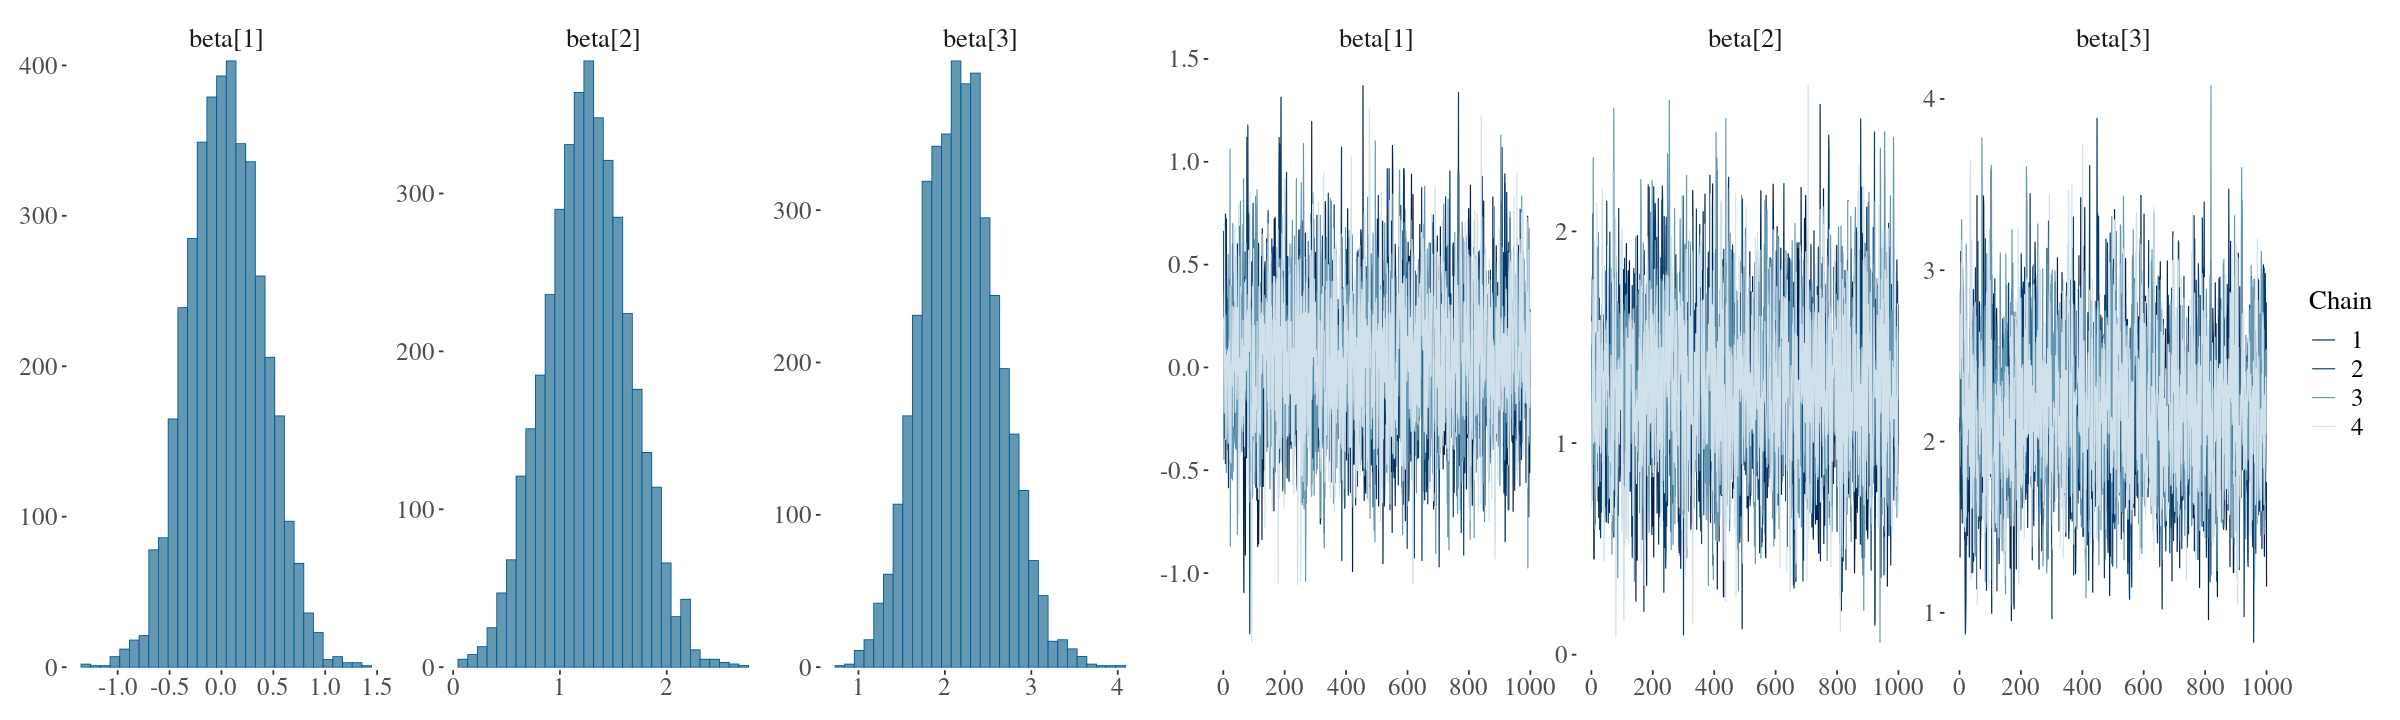

In [86]:
options(repr.plot.width = 20, repr.plot.height = 6)

trace.plot <- bayesplot::mcmc_trace(wine_fit_sratio, regex_pars = "beta") 
hist.plot  <- bayesplot::mcmc_hist(wine_fit_sratio, regex_pars = "beta")

(hist.plot + g) + (trace.plot + g)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



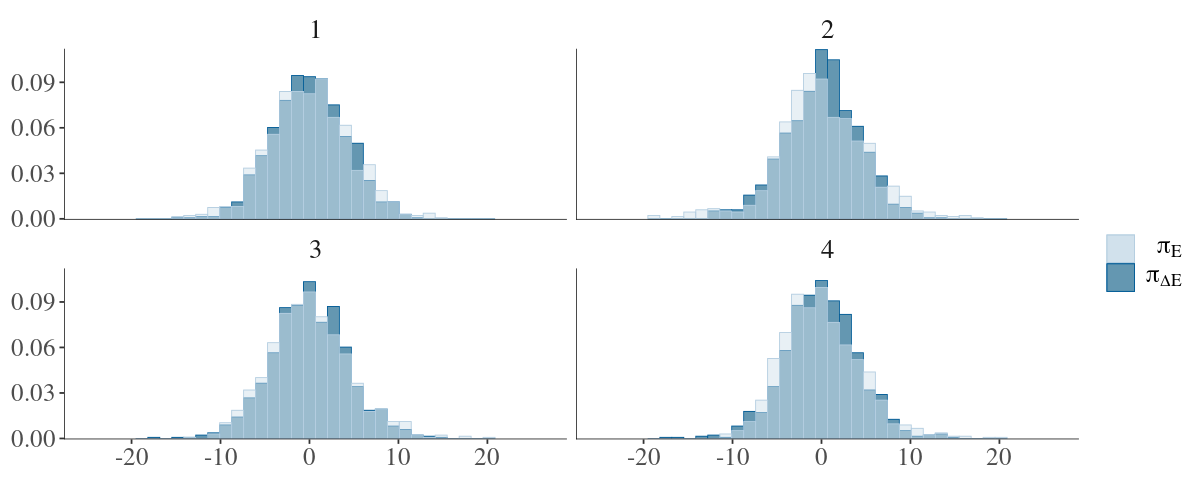

In [87]:
options(repr.plot.width = 10, repr.plot.height = 4)

params <- bayesplot::nuts_params(wine_fit_sratio)
bayesplot::mcmc_nuts_energy(params) + g

## Interpretation of coefficients

While the coefficients of the two models are fairly similar, the major difference lies in their interpretation. For the cumulative model the coefficients refer to the cumulative odds ratio

$$\begin{align}
\frac{P(Y \le k \mid \mathbf{x})\ / \ P(Y > k  \mid \mathbf{x}) }{P(Y \le k \mid \mathbf{\tilde{x}})\ / \ P(Y > k 
\mid \mathbf{\tilde{x}}) } 
& = \exp\left( \left(  \mathbf{x} - \mathbf{\tilde{x}}\right)^T \boldsymbol \beta  \right)
\end{align}$$ 

while they refer to a stopping odds ratio for the sequential model

$$\begin{align}
\frac{P(Y = k \mid Y \ge k, \mathbf{x})\ / \ P( Y > k \mid Y \ge k, \mathbf{x}) }{P(Y = k \mid Y \ge k, \mathbf{\tilde{x}})\ / \ P(Y > k \mid Y \ge k, \mathbf{\tilde{x}}) } 
& = \exp\left( \left(  \mathbf{x} - \mathbf{\tilde{x}}\right)^T \boldsymbol \beta  \right)
\end{align}$$ 


In [14]:
parse.summary <- function(fit, name) {
    summ <- data.frame(mean=rstan::summary(fit, pars="beta")$summary[, "mean"])
    summ$model <- name
    summ$feature <- c("bottle=2", "contact=yes", "temperature=high")
    summ
}

In [15]:
cumulative.summary  <- parse.summary(wine_fit_cumulative, "cumulative")
sratio.summary  <- parse.summary(wine_fit_sratio, "sequential")

rbind(cumulative.summary, sratio.summary) %>%
    tidyr::pivot_wider(values_from = "mean", names_from="feature")

model,bottle=2,contact=yes,temperature=high
<chr>,<dbl>,<dbl>,<dbl>
cumulative,0.18023282,1.392133,2.332921
sequential,0.03130708,1.263551,2.174483


For instance, for the cumulative model for the covariable `temperature` has the odds ratio

$$\begin{align}
\frac{P(Y \le k \mid temperature=high)\ / \ P(Y > k  \mid temperature=high) }{P(Y \le k \mid temperature=low)\ / \ P(Y > k 
\mid temperature=low) } 
& = \exp\left( 2.33 \right)
\end{align}$$ 

which means that for any rating level (from non-bitter to bitter) the odds for a **less bitter** rating in comparison to a **more bitter** rating are distictly higher when the grapes of the wine have been crushed with a high temperature, i.e., warmer crushing decreases the chances to be judged as bitter.

For the sequential model the covariable `temperature` has the odds ratio

$$\begin{align}
\frac{P(Y = k \mid Y \ge k, temperature=high)\ / \ P( Y > k \mid Y \ge k, temperature=high) }{P(Y = k \mid Y \ge k, temperature=low)\ / \ P(Y > k \mid Y \ge k, temperature=low) } 
& = \exp\left( 2.18 \right)
\end{align}$$ 

which means that the odds of stopping the transition to a higher bitterness is greater when the grapes have been crushed under high temperature, i.e., the chances of obtaining higher bitterness levels are lower when the grapes have been crushed when its warm.

## Model selection

We do a model comparison using approximate leave-one-out cross-validation using the [`loo`](https://github.com/stan-dev/loo) package.

In [19]:
do.loo <- function(fit) {
    ll <- loo::extract_log_lik(fit, merge_chains = FALSE)
    r_eff <- loo::relative_eff(exp(ll))
    loo::loo(ll, r_eff = r_eff)    
}

In [32]:
wine_cumulative_loo <- do.loo(wine_fit_cumulative)
wine_sratio_loo <- do.loo(wine_fit_sratio)

loos <- loo::loo_compare(
    list(cumulative=wine_cumulative_loo, sequential=wine_sratio_loo)
)

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”


In [33]:
print(loos, simplify=FALSE)

           elpd_diff se_diff elpd_loo se_elpd_loo p_loo se_p_loo looic se_looic
sequential   0.0       0.0   -86.8      4.7        11.9   1.4    173.7   9.4   
cumulative  -0.2       0.7   -87.1      4.7        12.0   1.2    174.1   9.4   


The expected log predictive density is higher for the sequential model. That's nice, because it demonstrates (as was the goal of this case study) that the sequential response mechanism is preferred for this data set.